In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
dataset=pd.read_csv('Dataset/creditcard.csv')

In [4]:
dataset.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
dataset.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
dataset.head(-100)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284702,172696.0,-0.481672,1.579297,-1.284154,-0.083524,0.097815,-1.421216,0.265490,0.528140,-0.307906,-1.331943,-1.005150,-0.263474,-0.359712,-0.228577,0.677596,0.359084,0.823061,0.916912,-0.128536,-0.380578,0.388981,0.931019,-0.114448,-0.196205,-0.350532,-0.156168,-0.242231,-0.000290,2.32,0
284703,172699.0,1.019594,-1.956473,-1.431268,0.539727,-0.499995,0.301251,0.326079,-0.062475,1.121288,-0.403165,-0.090503,1.230074,0.367173,0.173777,-0.563206,0.246397,-0.885793,0.368108,0.810866,0.849979,-0.081894,-1.202749,-0.182683,-1.075679,-0.417648,-1.080842,-0.049144,0.039078,521.90,0
284704,172700.0,-1.269721,1.555504,0.131330,-1.065236,0.107397,-0.307148,0.001854,0.678313,0.459493,-1.409373,-1.749021,-0.335999,0.015538,-1.098655,0.473234,1.015379,0.233166,0.805932,0.115058,-0.095322,-0.254000,-0.744358,-0.155462,-1.143492,-0.136877,-0.245317,-0.315736,-0.135902,0.77,0
284705,172700.0,1.661170,-0.776159,-0.641425,0.373346,-0.503214,-0.187082,-0.217116,-0.029741,0.842554,-0.085992,0.700722,1.519640,0.881897,0.068251,-0.106756,0.454024,-0.959484,0.282056,0.341769,0.174745,-0.093155,-0.490798,0.179927,-0.428102,-0.448987,-0.678428,0.000639,-0.015738,169.29,0


In [8]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
total_null_values=dataset.isnull().sum().sort_values(ascending=False)
total_null_values

Time      0
V16       0
Amount    0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
V21       0
V20       0
V19       0
V18       0
V17       0
V15       0
V1        0
V14       0
V13       0
V12       0
V11       0
V10       0
V9        0
V8        0
V7        0
V6        0
V5        0
V4        0
V3        0
V2        0
Class     0
dtype: int64

Text(0, 0.5, 'count')

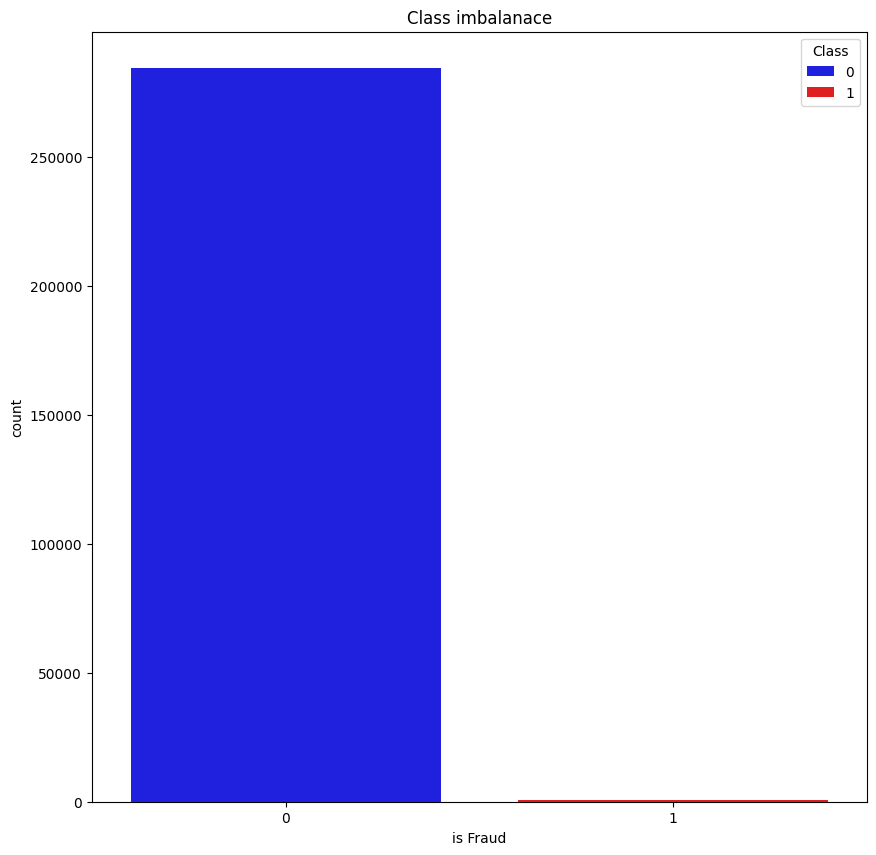

In [10]:
palette1={0:'blue',1:'red'}
plt.figure(figsize=(10,10))
sns.countplot(x='Class',data=dataset,hue='Class',palette=palette1)
plt.title("Class imbalanace")
plt.xlabel('is Fraud')
plt.ylabel('count')

For checking the imbalance in the data set

C:\Users\HP\AppData\Local\Temp\ipykernel_20332\3465083911.py:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\HP\AppData\Local\Temp\ipykernel_20332\3465083911.py:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




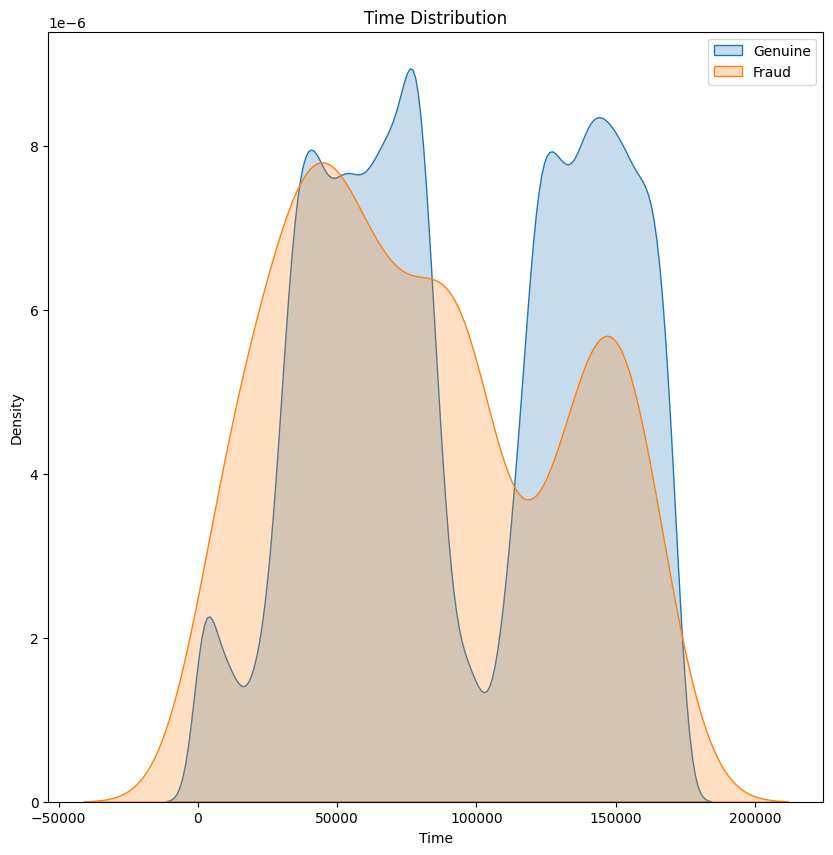

In [11]:
plt.figure(figsize=(10,10))
sns.kdeplot(dataset.loc[dataset['Class']==0]['Time'],label='Genuine',shade=True)
sns.kdeplot(dataset[dataset['Class']==1]['Time'],label='Fraud',shade=True)
plt.title('Time Distribution')
plt.xlabel('Time')
plt.ylabel('Density')
plt.legend()


In [12]:
dataset['time_hour']=np.floor(dataset['Time']/3600)
tmp = dataset.groupby(['time_hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()

In [13]:
data_set=pd.DataFrame(tmp)
data_set.columns=['time_hour','Class','min','max','count','sum','mean','median','var']

In [14]:
data_set.head()

,time_hour,Class,min,max,count,sum,mean,median,var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


In [15]:
max(data_set['time_hour'])

47.0

<Axes: xlabel='time_hour', ylabel='sum'>

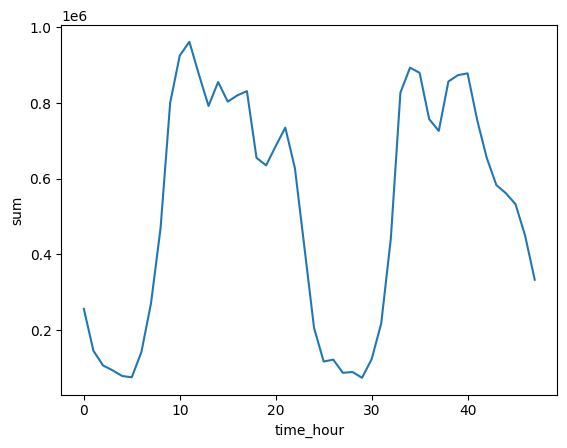

In [16]:
sns.lineplot(x='time_hour',y='sum',data=data_set[data_set['Class']==0])


<Axes: xlabel='time_hour', ylabel='sum'>

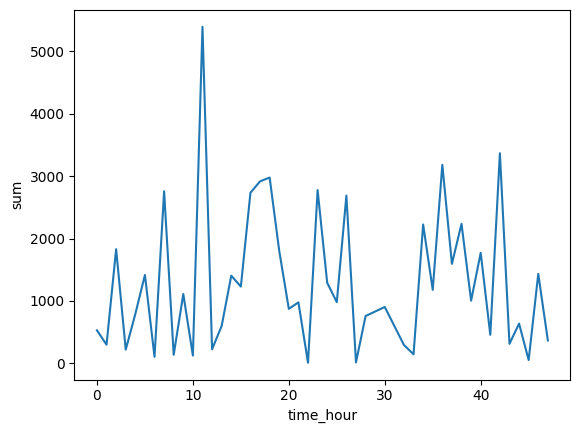

In [17]:
sns.lineplot(x='time_hour',y='sum',data=data_set[data_set['Class']==1])

9881

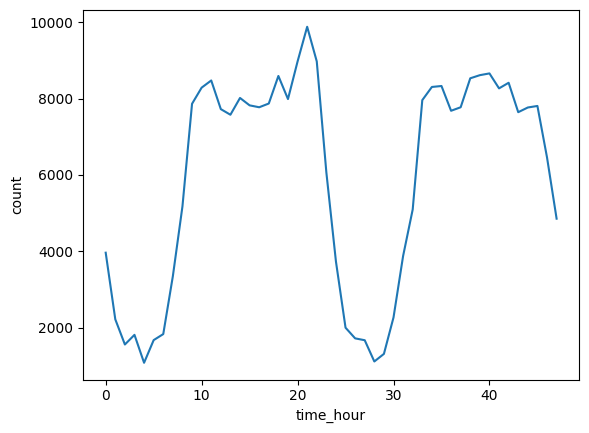

In [18]:
sns.lineplot(x='time_hour',y='count',data=data_set[data_set['Class']==0])

max(data_set[data_set['Class'] == 0]['count'])


<Axes: xlabel='time_hour', ylabel='count'>

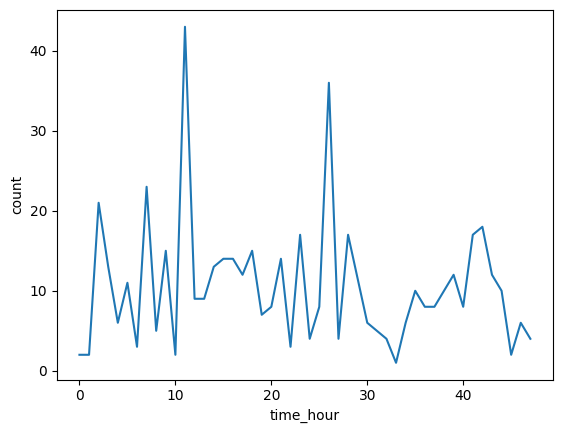

In [19]:
sns.lineplot(x='time_hour', y='count', data=data_set[data_set['Class'] == 1])


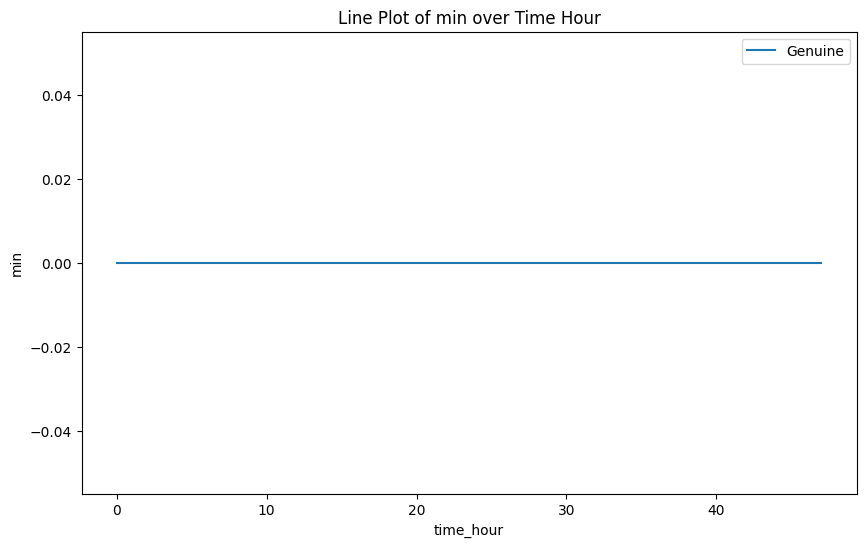

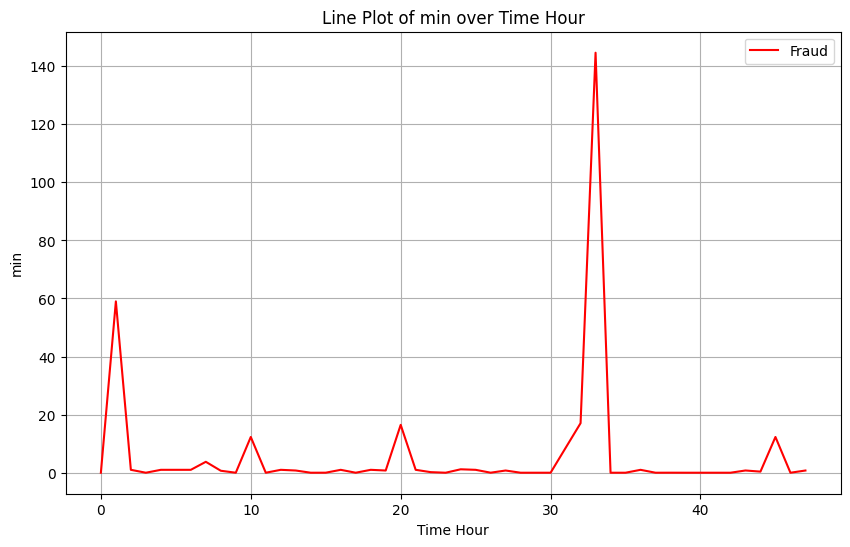

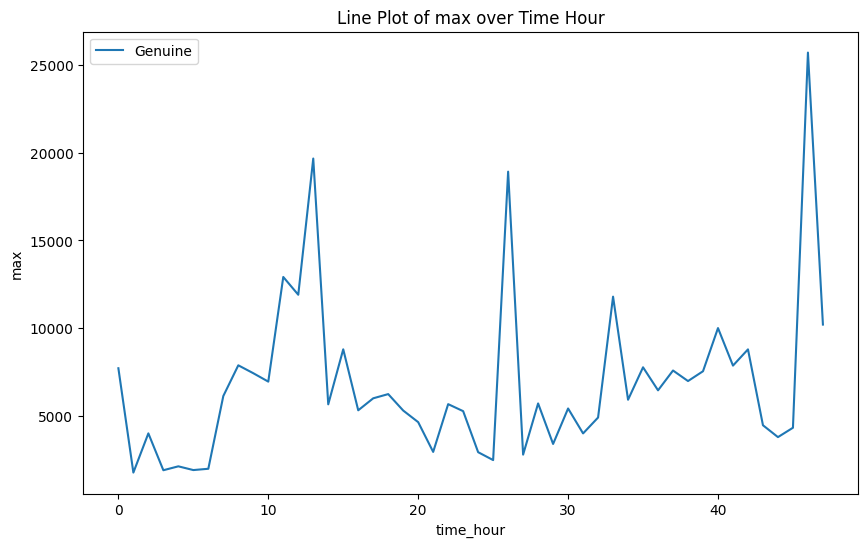

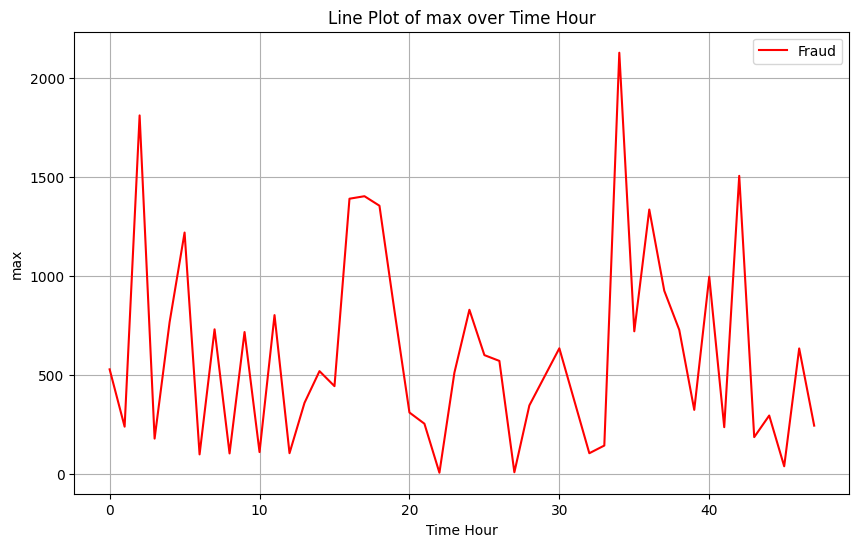

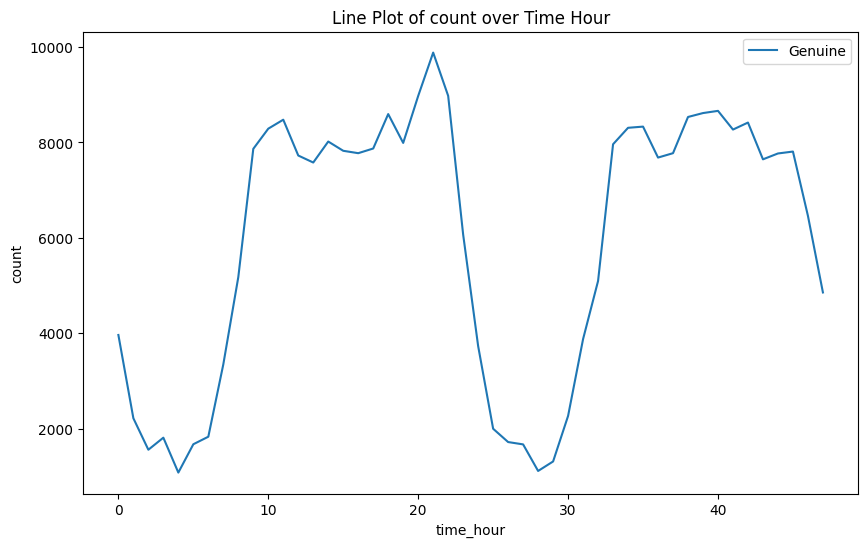

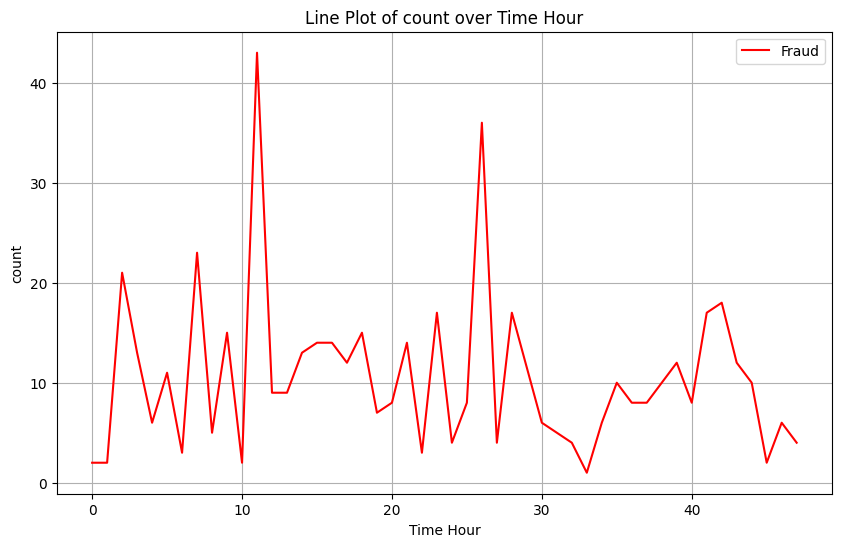

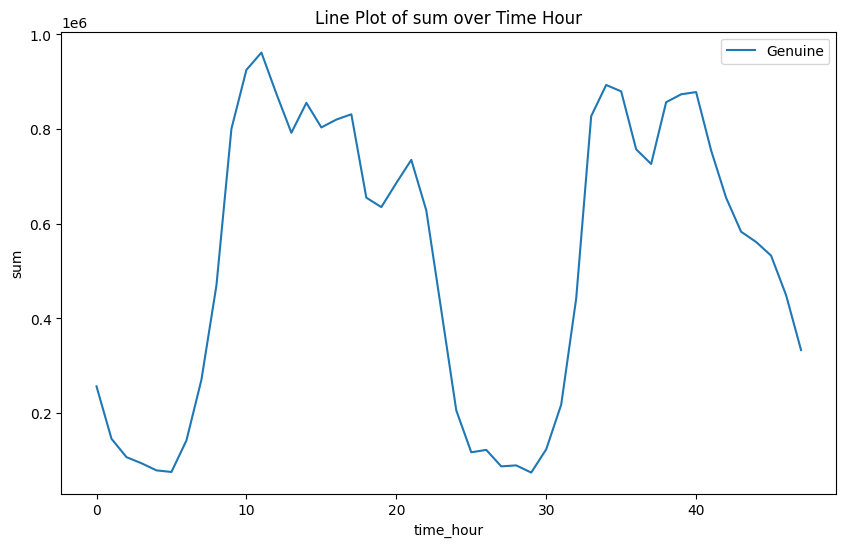

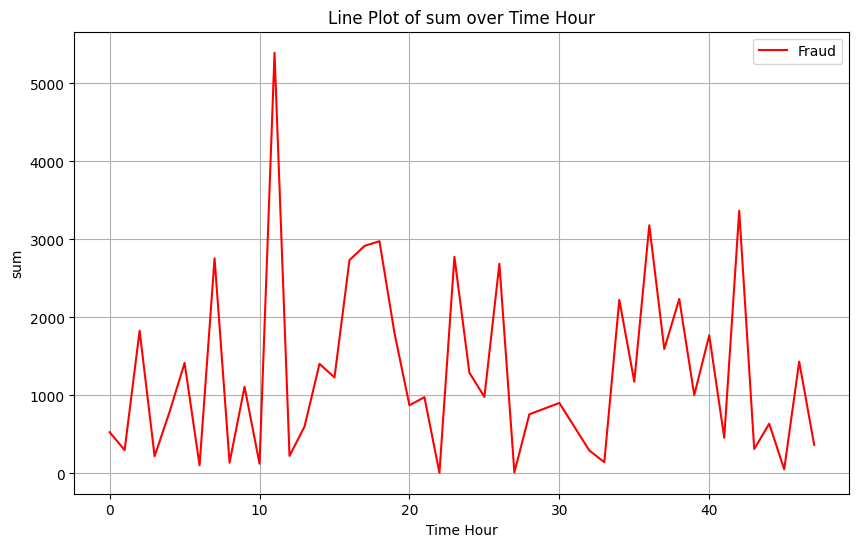

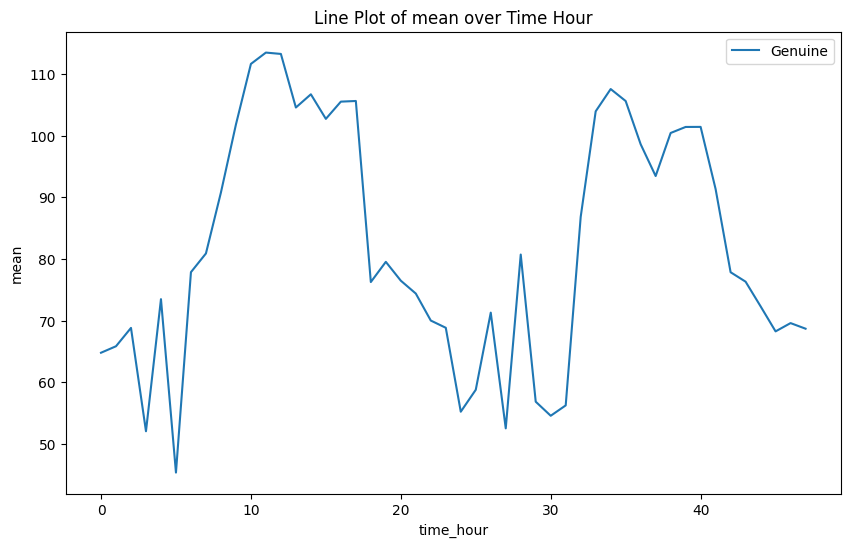

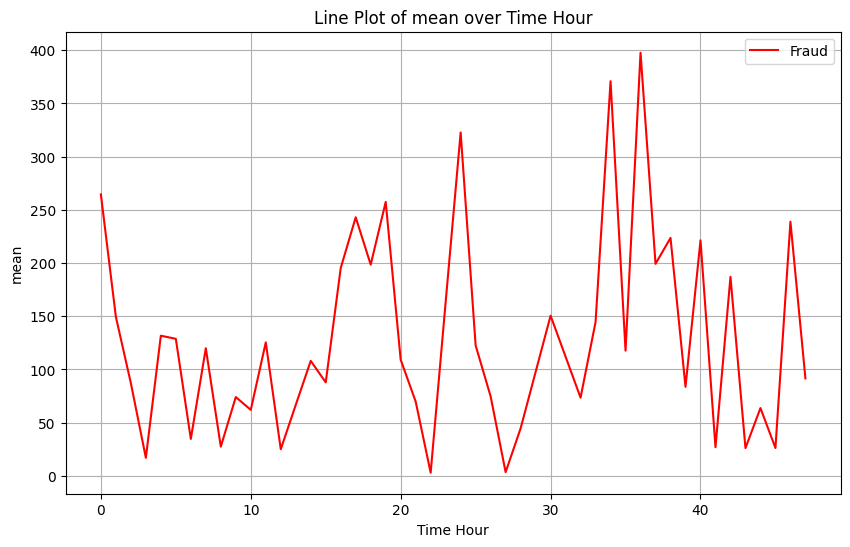

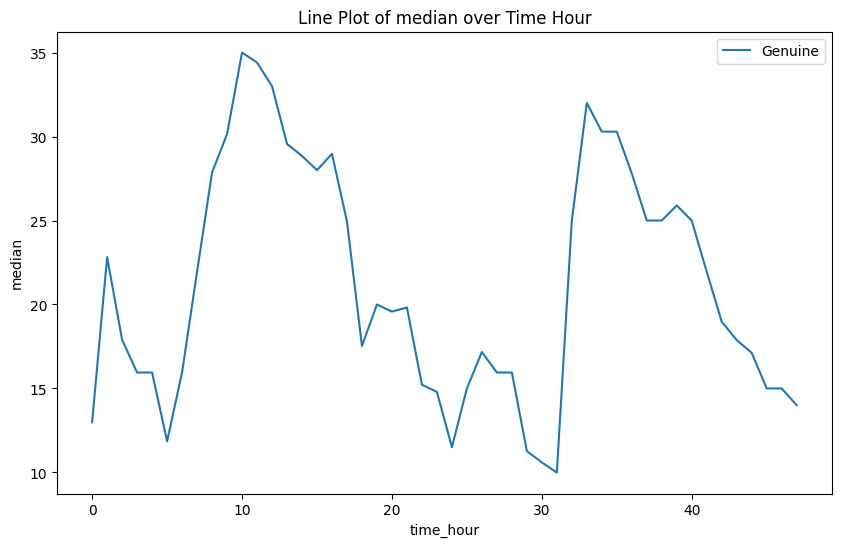

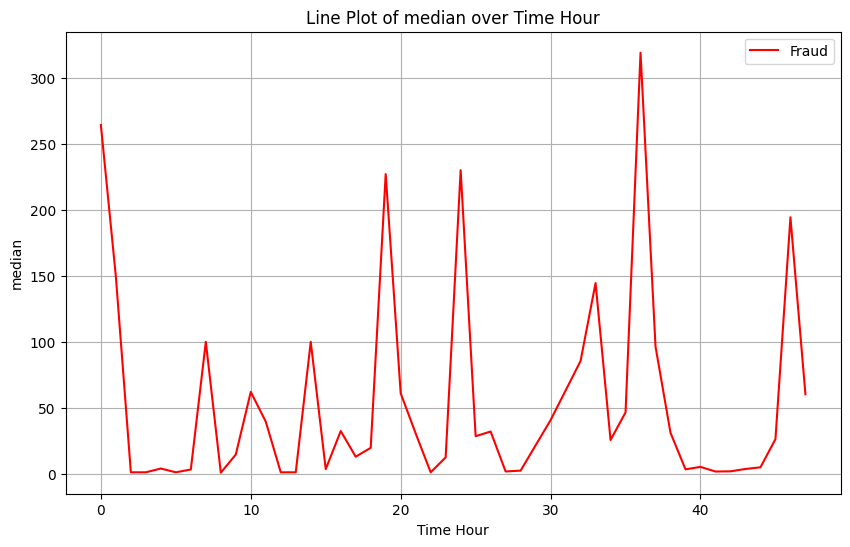

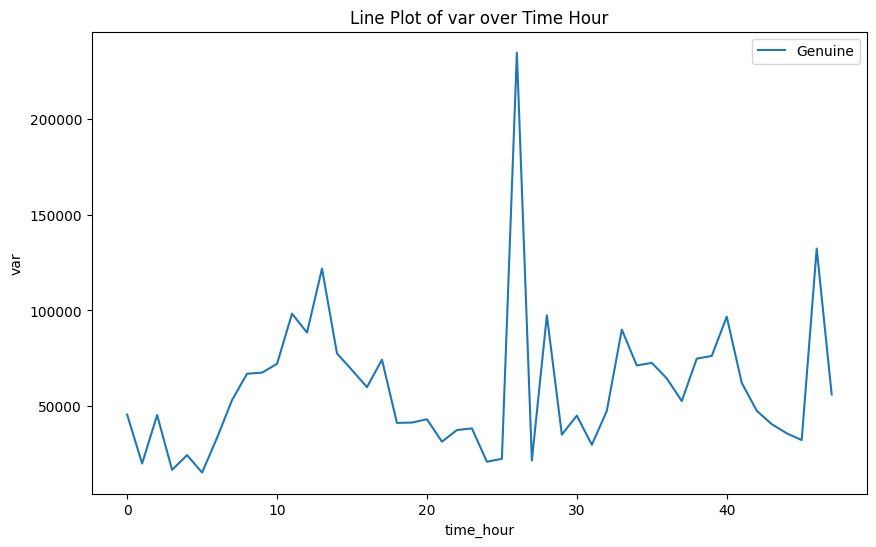

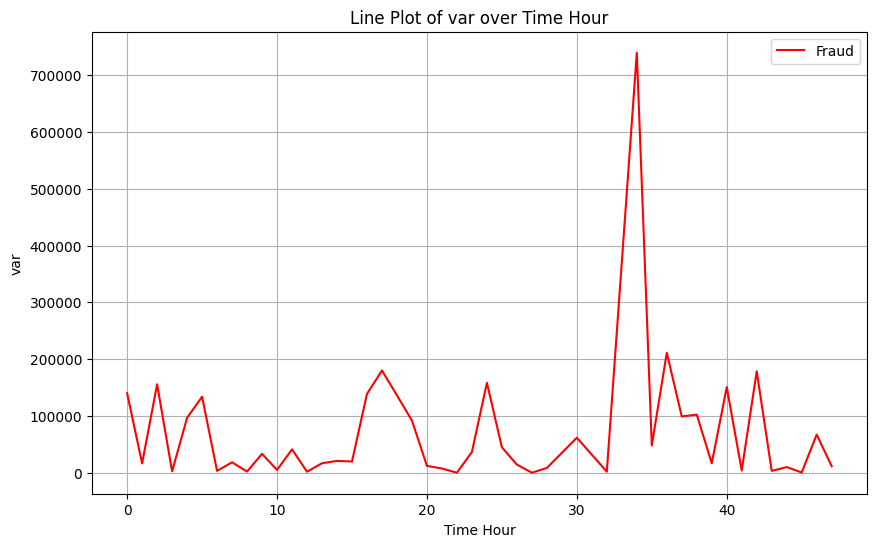

In [20]:

features = data_set.columns.tolist()
features.remove('time_hour')
features.remove('Class')

# Create a line plot for each feature
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='time_hour', y=feature, data=data_set[data_set['Class'] == 0], label='Genuine')
    plt.title(f'Line Plot of {feature} over Time Hour')

    plt.figure(figsize=(10,6))
    sns.lineplot(x='time_hour',y=feature,data=data_set[data_set['Class']==1],label='Fraud',color='red')

    plt.title(f'Line Plot of {feature} over Time Hour')
    plt.xlabel('Time Hour')
    plt.ylabel(feature)
    plt.grid(True)
    plt.show()


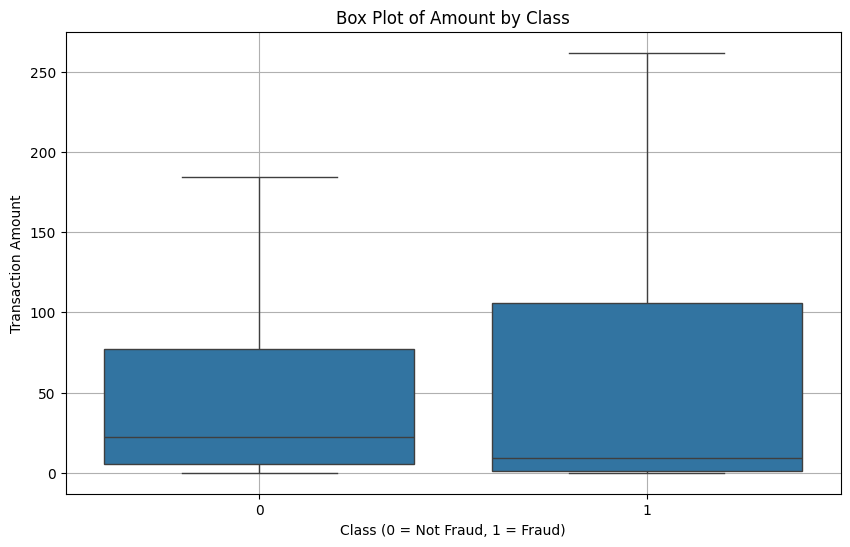

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=dataset,showfliers=False)
plt.title('Box Plot of Amount by Class')
plt.xlabel('Class (0 = Not Fraud, 1 = Fraud)')
plt.ylabel('Transaction Amount')
plt.grid(True)
plt.show()


Checking the relation between Fraud transaction based on the various value we are going to get from the below operations



In [22]:
amount_dataset = dataset[['Amount', 'Class']].copy()  # Create a copy of the Amount and Class columns
class0_amount = amount_dataset[amount_dataset['Class'] == 0]['Amount']  # Filter for Class 0 and select Amount
class1_amount=amount_dataset[amount_dataset['Class']==1]['Amount']


In [23]:
class0_amount.describe()  

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [24]:
class1_amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [25]:
data_set.columns

Index(['time_hour', 'Class', 'min', 'max', 'count', 'sum', 'mean', 'median',
       'var'],
      dtype='object')

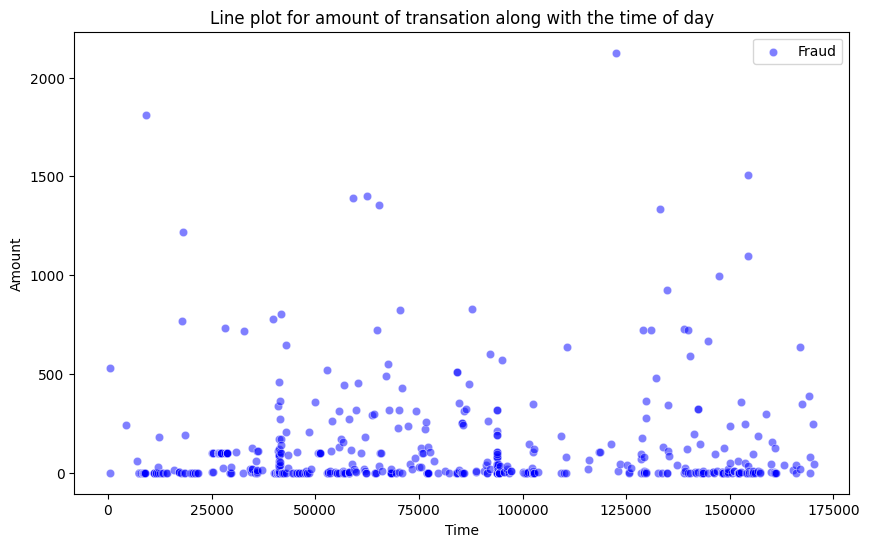

In [26]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x='Time',y='Amount',data=dataset[dataset['Class']==1],label='Fraud',color='blue',alpha=0.5)
plt.title("Line plot for amount of transation along with the time of day")
plt.show()

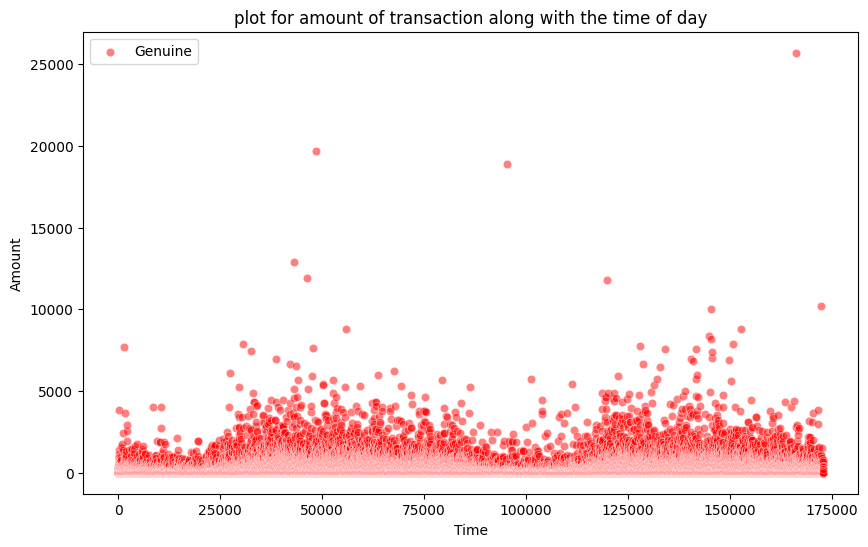

In [27]:
plt.figure(figsize=(10,6))

sns.scatterplot(x='Time',y='Amount',data=dataset[dataset['Class']==0],label='Genuine',color='red',alpha=0.5)
plt.title('plot for amount of transaction along with the time of day')
plt.show()

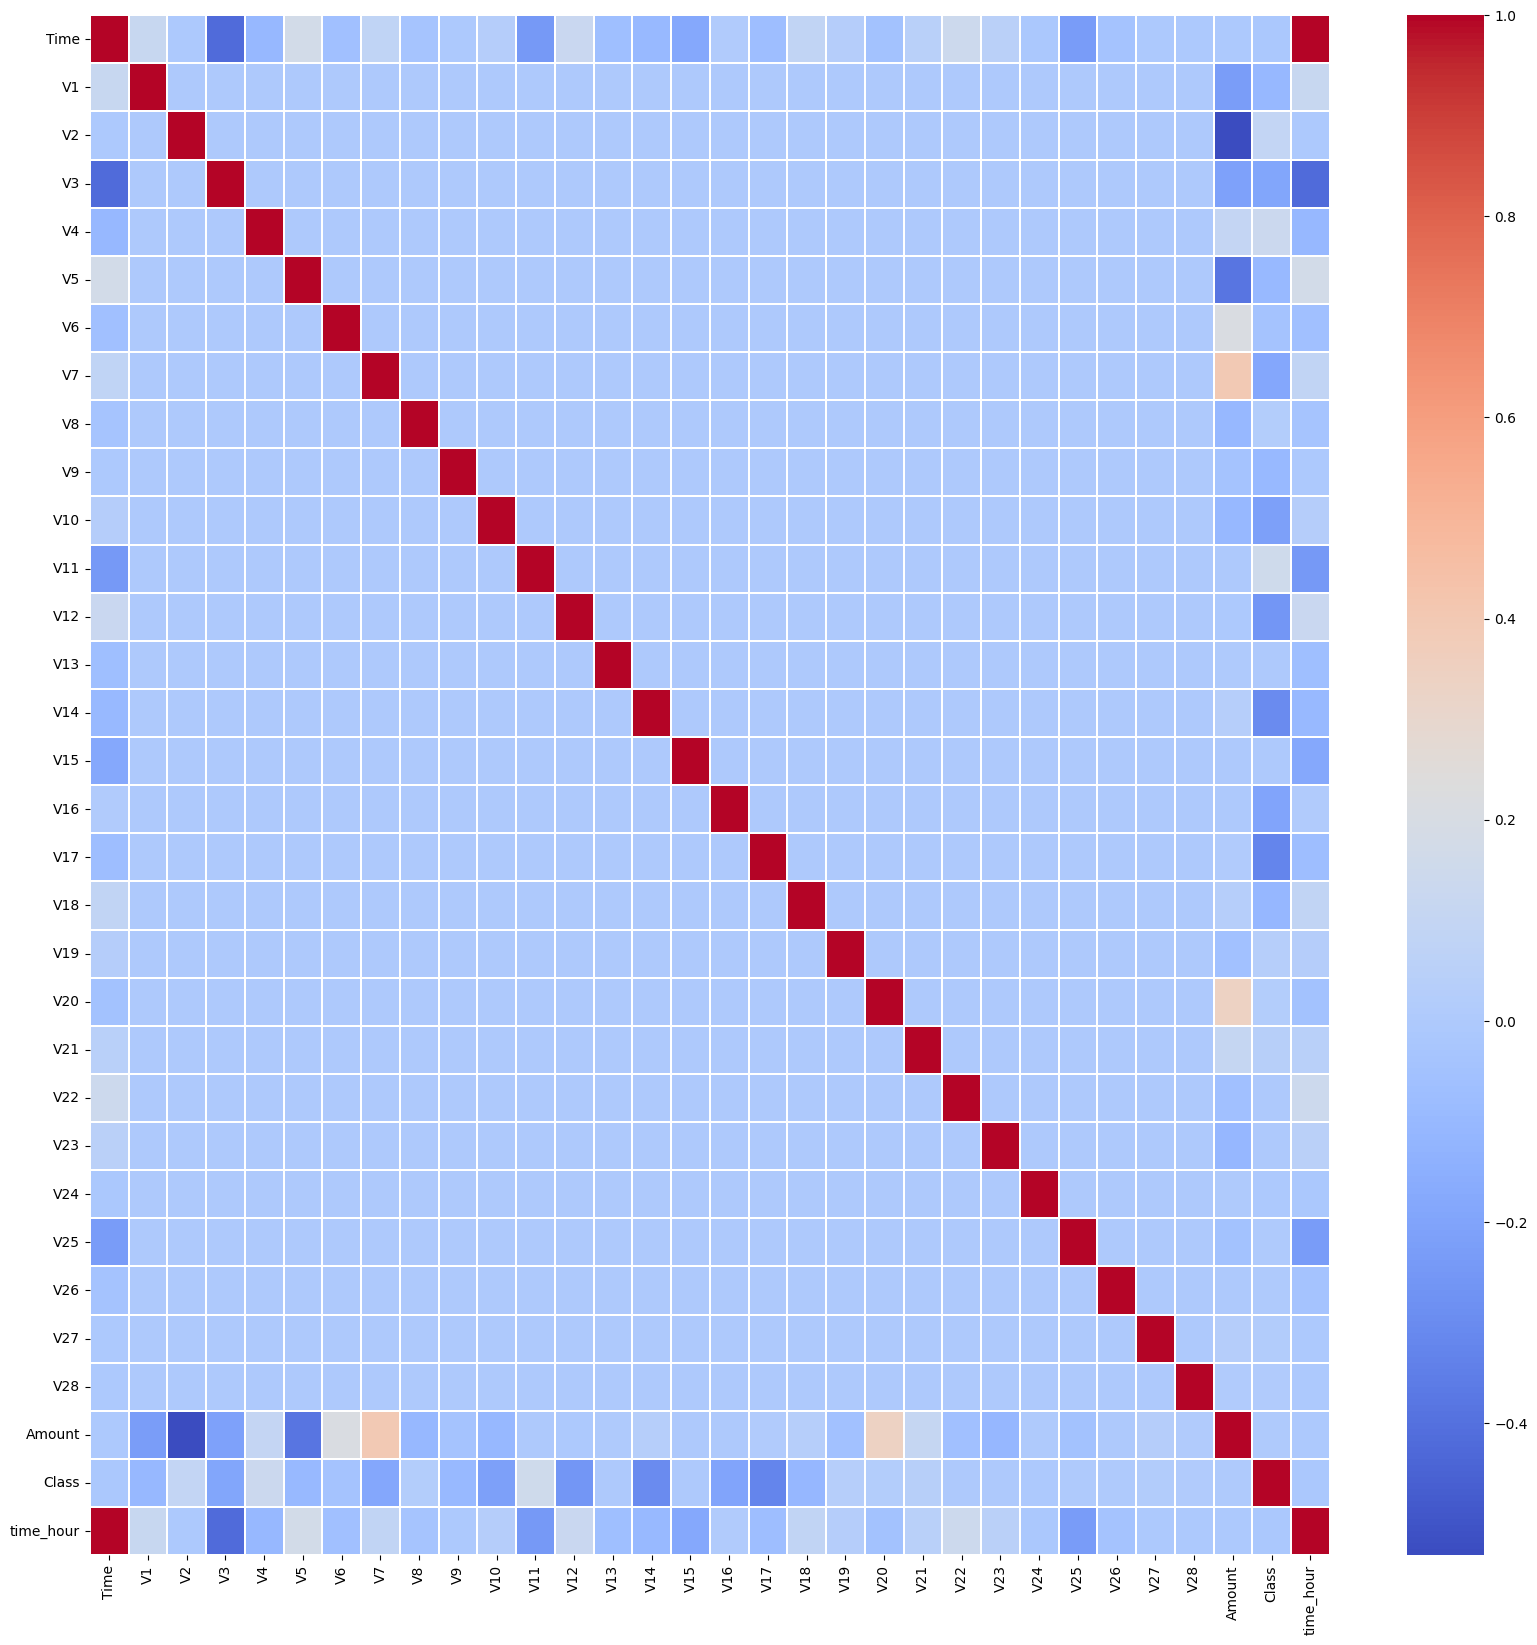

In [28]:
plt.figure(figsize=(20,20))

corr=dataset.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap='coolwarm')
plt.show()



In [29]:
corr

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,time_hour
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,3.061663e-02,-2.476894e-01,1.243481e-01,-6.590202e-02,-9.875682e-02,-1.834533e-01,1.190287e-02,-7.329721e-02,9.043813e-02,2.897530e-02,-5.086602e-02,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323,0.999758
V1,0.117396,1.000000e+00,4.135835e-16,-1.227819e-15,-9.215150e-16,1.812612e-17,-6.506567e-16,-1.005191e-15,-2.433822e-16,-1.513678e-16,7.388135e-17,2.125498e-16,2.053457e-16,-2.425603e-17,-5.020280e-16,3.547782e-16,7.212815e-17,-3.879840e-16,3.230206e-17,1.502024e-16,4.654551e-16,-2.457409e-16,-4.290944e-16,6.168652e-16,-4.425156e-17,-9.605737e-16,-1.581290e-17,1.198124e-16,2.083082e-15,-0.227709,-0.101347,0.117666
V2,-0.010593,4.135835e-16,1.000000e+00,3.243764e-16,-1.121065e-15,5.157519e-16,2.787346e-16,2.055934e-16,-5.377041e-17,1.978488e-17,-3.991394e-16,1.975426e-16,-9.568710e-17,6.295388e-16,-1.730566e-16,-4.995814e-17,1.177316e-17,-2.685296e-16,3.284605e-16,-7.118719e-18,2.506675e-16,-8.480447e-17,1.526333e-16,1.634231e-16,1.247925e-17,-4.478846e-16,2.057310e-16,-4.966953e-16,-5.093836e-16,-0.531409,0.091289,-0.010628
V3,-0.419618,-1.227819e-15,3.243764e-16,1.000000e+00,4.711293e-16,-6.539009e-17,1.627627e-15,4.895305e-16,-1.268779e-15,5.568367e-16,1.156587e-15,1.576830e-15,6.310231e-16,2.807652e-16,4.739859e-16,9.068793e-16,8.299445e-16,7.614712e-16,1.509897e-16,3.463522e-16,-9.316409e-16,5.706192e-17,-1.133902e-15,-4.983035e-16,2.686834e-19,-1.104734e-15,-1.238062e-16,1.045747e-15,9.775546e-16,-0.210880,-0.192961,-0.419601
V4,-0.105260,-9.215150e-16,-1.121065e-15,4.711293e-16,1.000000e+00,-1.719944e-15,-7.491959e-16,-4.104503e-16,5.697192e-16,6.923247e-16,2.232685e-16,3.459380e-16,-5.625518e-16,1.303306e-16,2.282280e-16,1.377649e-16,-9.614528e-16,-2.699612e-16,-5.103644e-16,-3.980557e-16,-1.857247e-16,-1.949553e-16,-6.276051e-17,9.164206e-17,1.584638e-16,6.070716e-16,-4.247268e-16,3.977061e-17,-2.761403e-18,0.098732,0.133447,-0.105237
V5,0.173072,1.812612e-17,5.157519e-16,-6.539009e-17,-1.719944e-15,1.000000e+00,2.408382e-16,2.715541e-16,7.437229e-16,7.391702e-16,-5.202306e-16,7.203963e-16,7.412552e-16,5.886991e-16,6.565143e-16,-8.720275e-16,2.246261e-15,1.281914e-16,5.308590e-16,-1.450421e-16,-3.554057e-16,-3.920976e-16,1.253751e-16,-8.428683e-18,-1.149255e-15,4.808532e-16,4.319541e-16,6.590482e-16,-5.613951e-18,-0.386356,-0.094974,0.173212
V6,-0.063016,-6.506567e-16,2.787346e-16,1.627627e-15,-7.491959e-16,2.408382e-16,1.000000e+00,1.191668e-16,-1.104219e-16,4.131207e-16,5.932243e-17,1.980503e-15,2.375468e-16,-1.211182e-16,2.621312e-16,-1.531188e-15,2.623672e-18,2.015618e-16,1.223814e-16,-1.865597e-16,-1.858755e-16,5.833316e-17,-4.705235e-19,1.046712e-16,-1.071589e-15,4.562861e-16,-1.357067e-16,-4.452461e-16,2.594754e-16,0.215981,-0.043643,-0.062980
V7,0.084714,-1.005191e-15,2.055934e-16,4.895305e-16,-4.104503e-16,2.715541e-16,1.191668e-16,1.000000e+00,3.344412e-16,1.122501e-15,-7.492834e-17,1.425248e-16,-3.536655e-18,1.266462e-17,2.607772e-16,-1.690540e-16,5.869302e-17,2.177192e-16,7.604126e-17,-1.881008e-16,9.379684e-16,-2.027779e-16,-8.898922e-16,-4.387401e-16,7.434913e-18,-3.094082e-16,-9.657637e-16,-1.782106e-15,-2.776530e-16,0.397311,-0.187257,0.084751
V8,-0.036949,-2.433822e-16,-5.377041e-17,-1.268779e-15,5.697192e-16,7.437229e-16,-1.104219e-16,3.344412e-16,1.000000e+00,4.356078e-16,-2.801370e-16,2.487043e-16,1.839891e-16,-2.921856e-16,-8.599156e-16,4.127777e-16,-5.254741e-16,-2.269549e-16,-3.667974e-16,-3.875186e-16,2.033737e-16,3.892798e-16,2.026927e-16,6.377260e-17,-1.047097e-16,-4.653279e-16,-1.727276e-16,1.299943e-16,-6.200930e-16,-0.103079,0.019875,-0.037051
V9,-0.008660,-1.513678e-16,1.978488e-17,5.568367e-16,6.923247e-16,7.391702e-16,4.131207e-16,1.122501e-

In [36]:
threshold = 0.9998
high_corr_pairs = corr[(corr > threshold) & (corr < 1)].stack()


In [37]:
high_corr_pairs

Series([], dtype: float64)